# Clustering first attempt

In [290]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

# import dataset
df_original_copy = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True)
df = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

In [291]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [292]:
#Changing udm to duration_ms and features_duration_ms from ms to min
df['duration_ms'] *= 1/6e4
#Setting popularity as a %
df['popularity'] /= 100
df.rename(columns = {'duration_ms':'duration_min'}, inplace = True)

In [372]:
max(df['duration_min'])
#need to set a lim? need to analyse long tracks in data preparation

46.6164

In [293]:
#Creating genre map -> mapping every genre into an int value in order to have correlation values. 
#Redoing Pearson correlation adding genre category
df['genre'].value_counts()
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
df.replace({'genre':genre_map}).corr(numeric_only=True).style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1) #!!!

## Clustering searching for genre division 
I want to cluster considering only 'musical features', that are the 'technical' ones. The idea is to find the already-given division by genre.  
It is interesting, in case this works, to do a **hierarchical clustering** in order to search for 'base' genres and subgenres. 

The interesting features for the scope could be:
- `duration_min`
- `key` (discrete); 
- `mode` (discrete);
- `speechiness`;
- `acousticness`;
- `instrumentalness`;
- `tempo`;
- `time_signature`;
- `n_beats`;
- `n_bars`;  
being the latter two highly correlated with `duration_ms`, just the former is necessary. 
also `genre` in order to check the results.  
Being those the interesting attributes, a goal-specific data understanding will be done only on this data. 

Because K-means algorithm works only with continuous attributes, also a data subset with the following attributes is created and used:
- `duration_min`
- `popularity`;
- `danceability`;
- `energy`;
- `loudness`;
- `speechiness`;
- `acousticness`;
- `instrumentalness`;
- `liveness`;
- `valence`;
- `tempo`.

### Outlier criterion
The outlier criterion for the following scope is composed by the following cut:
- `time_sigmature` > 1.0, in order to select only _music tracks_, where the features taken into spot are all well-defined;
- the first criterion ideally is enough but `sleep` tracks containing noise sounds often are bad-detected by the algorithm. Bc of that, in this first phase the `sleep` tracks are all excluded. 

### Data preparation

In [298]:
#Dealing with mode attribute missing values
#Computing p0 and p1 and filling missing values of mode attribute by sampling
#df['mode'].value_counts().plot(kind='bar', title='mode')
p0=df['mode'].value_counts()[0]/(len(df)-df['mode'].isnull().sum())
p1=df['mode'].value_counts()[1]/(len(df)-df['mode'].isnull().sum())
#print(f'p0={p0} , p1={p1}')
list_of_nan_indexes=df[df['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes:
    #df.loc[i,'mode']
    #df.loc[['viper', 'sidewinder'], ['shield']] = 50
    if np.random.random() < p1:
        df.loc[i,'mode'] = 1.0
    else:
        df.loc[i,'mode'] = 0.0

In [299]:
#Dealing with time_signature attribute missing values
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df['time_signature'].value_counts())
p_array=np.array(df['time_signature'].value_counts().sort_index(ascending=True)/(len(df)-df['time_signature'].isnull().sum()))
print(p_array)
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df[df['time_signature'].isnull()].index.tolist()
#print(list_of_nan_indexes)
print(len(list_of_nan_indexes_ts))
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df.loc[i,'time_signature'] = dict_ts[index]

[0.08330377 0.89221599 0.02448024]
0


In [300]:
#Deleting outliers
df = df[(df['time_signature'] >1) & (df['genre'].str.contains('sleep')==False)]

In [301]:
#Selecting only the specific columns for the dataset
dfc=df[['duration_min','key', 'mode','speechiness','acousticness','instrumentalness','tempo','time_signature']]
dfc2=df[['duration_min','popularity', 'danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]

In [302]:
dfc2

duration_min  popularity  danceability  energy  loudness  speechiness  \
0          4.029333        0.46         0.690   0.513   -12.529       0.0975   
1          7.400000        0.00         0.069   0.196   -24.801       0.0805   
2          5.558433        0.03         0.363   0.854    -7.445       0.0397   
3          4.496667        0.23         0.523   0.585    -5.607       0.0765   
4          5.127517        0.25         0.643   0.687   -11.340       0.0539   
...             ...         ...           ...     ...       ...          ...   
14994      3.750700        0.16         0.570   0.875    -5.065       0.0700   
14995      7.200433        0.00         0.554   0.657   -14.232       0.0558   
14997      6.668183        0.43         0.799   0.535    -9.103       0.0594   
14998      3.287500        0.37         0.511   0.970    -2.299       0.0531   
14999      3.306817        0.36         0.678   0.518    -7.790       0.0352   

       acousticness  instrumentalness  liveness  valence    tempo  
0          0.302000          0.536000    0.2810   0.6350  142.221  
1          0.283000          0.934000    0.3600   0.0336   75.596  
2          0.000089          0.800000    0.2620   0.4890  116.628  
3          0.066400          0.001270    0.1170   0.3850  140.880  
4          0.000576          0.096900    0.2990   0.6370  143.956  
...             ...               ...       ...      ...      ...  
14994      0.033400          0.002890    0.3390   0.8020  175.017  
14995      0.016000          0.615000    0.1320   0.0335  117.319  
14997      0.001830          0.857000    0.0713   0.0708  126.000  
14998      0.000337          0.000014    0.4020   0.2700  160.044  
14999      0.463000          0.000000    0.0880   0.7840   88.003  

[14093 rows x 11 columns]

### Measure definition
Being some of those attributes _categorical_, such as `time_signature`, it is necessary to define a custom distance, that encorporates the Euclidean distance for continuous attributes and the dissimilarity concept of distance for categorical attributes.

In [154]:
#Reindexing columns just for defining in an easier manner the custom metric
column_names = ['key','duration_min', 'speechiness', 'acousticness',
       'instrumentalness', 'tempo','mode','time_signature']
column_names2 = ['duration_min','popularity', 'danceability','energy',
                 'loudness','speechiness','acousticness','instrumentalness',
                 'liveness','valence','tempo']

dfc = dfc.reindex(columns=column_names)
dfc.columns

NameError: name 'dfc2' is not defined

The pitch class notation is round-shaped, so, for the `key` it is necessary to define the distance using the module operation.  
The `time_signature` attribute is only categorical, not ordinal.

In some sense, it is the case, think about the following sentence: 'this song is two tones lower than this other'.

In [102]:
attribute_type_dict = {'key':'key','mode':'categorical','speechiness':'continuous',
                       'acousticness':'continuous','instrumentalness':'continuous',
                       'tempo':'continuous','time_signature':'categorical'}  

In [145]:
from scipy.spatial.distance import seuclidean, jaccard
# Defining the metric
# When the attribute is continuous, then the euclidean measure is used,
# when the attribute is categorical, dissimilarity is computed. 
# In order to distinguish the kind of attribute for the metric, 
# a dict is created, it will be used inside the metric function.
def custom_distance(x1 : np.array, x2 : np.array) -> float:
    index1=0
    index2=5
    index3=7
    d_key = abs((x1[0:index1+1][0]/0.27937800999999984)-(x2[0:index1+1][0]/0.27937800999999984))
    if(d_key<=6):
        d_key*=0.27937800999999984  
    else:
        d_key=(d_key%12)*0.27937800999999984
    #defining as metric the dissimilarity for categorical attributes
    #using jaccard dissimilarity
    d_cat = jaccard(x1[index1:index2+1], x2[index1:index2+1])
    #defining the std Euclidean metric for continuous attributes
    d_con = seuclidean(x1[index2:index3+1], x2[index2:index3+1], V=np.ones(index3+1-index2))
    distance = d_key+d_cat+d_con
    #print(type(distance))
    return distance
    

In [303]:
X = dfc.values
X2 = dfc2.values

In [147]:
custom_distance(X[0], X[0])

0.0

In [148]:
D = pdist(X, custom_distance)
D = squareform(D)
print(D)

[[ 0.         68.27996815 29.593      ... 17.86846388 18.65633333
  56.218     ]
 [68.27996815  0.         43.0441838  ... 51.24725221 86.10138448
  15.09469847]
 [29.593      43.0441838   0.         ... 11.372      47.416
  30.27246388]
 ...
 [17.86846388 51.24725221 11.372      ...  0.         35.69146388
  40.64446388]
 [18.65633333 86.10138448 47.416      ... 35.69146388  0.
  74.041     ]
 [56.218      15.09469847 30.27246388 ... 40.64446388 74.041
   0.        ]]


### Normalization (or, standardization)
It is necessary to choose a type of normalization. Looking at the distributions of the attributes for the scope, it is possible to decide with some criteria, see: https://developers.google.com/machine-learning/data-prep/transform/normalization?hl=en .

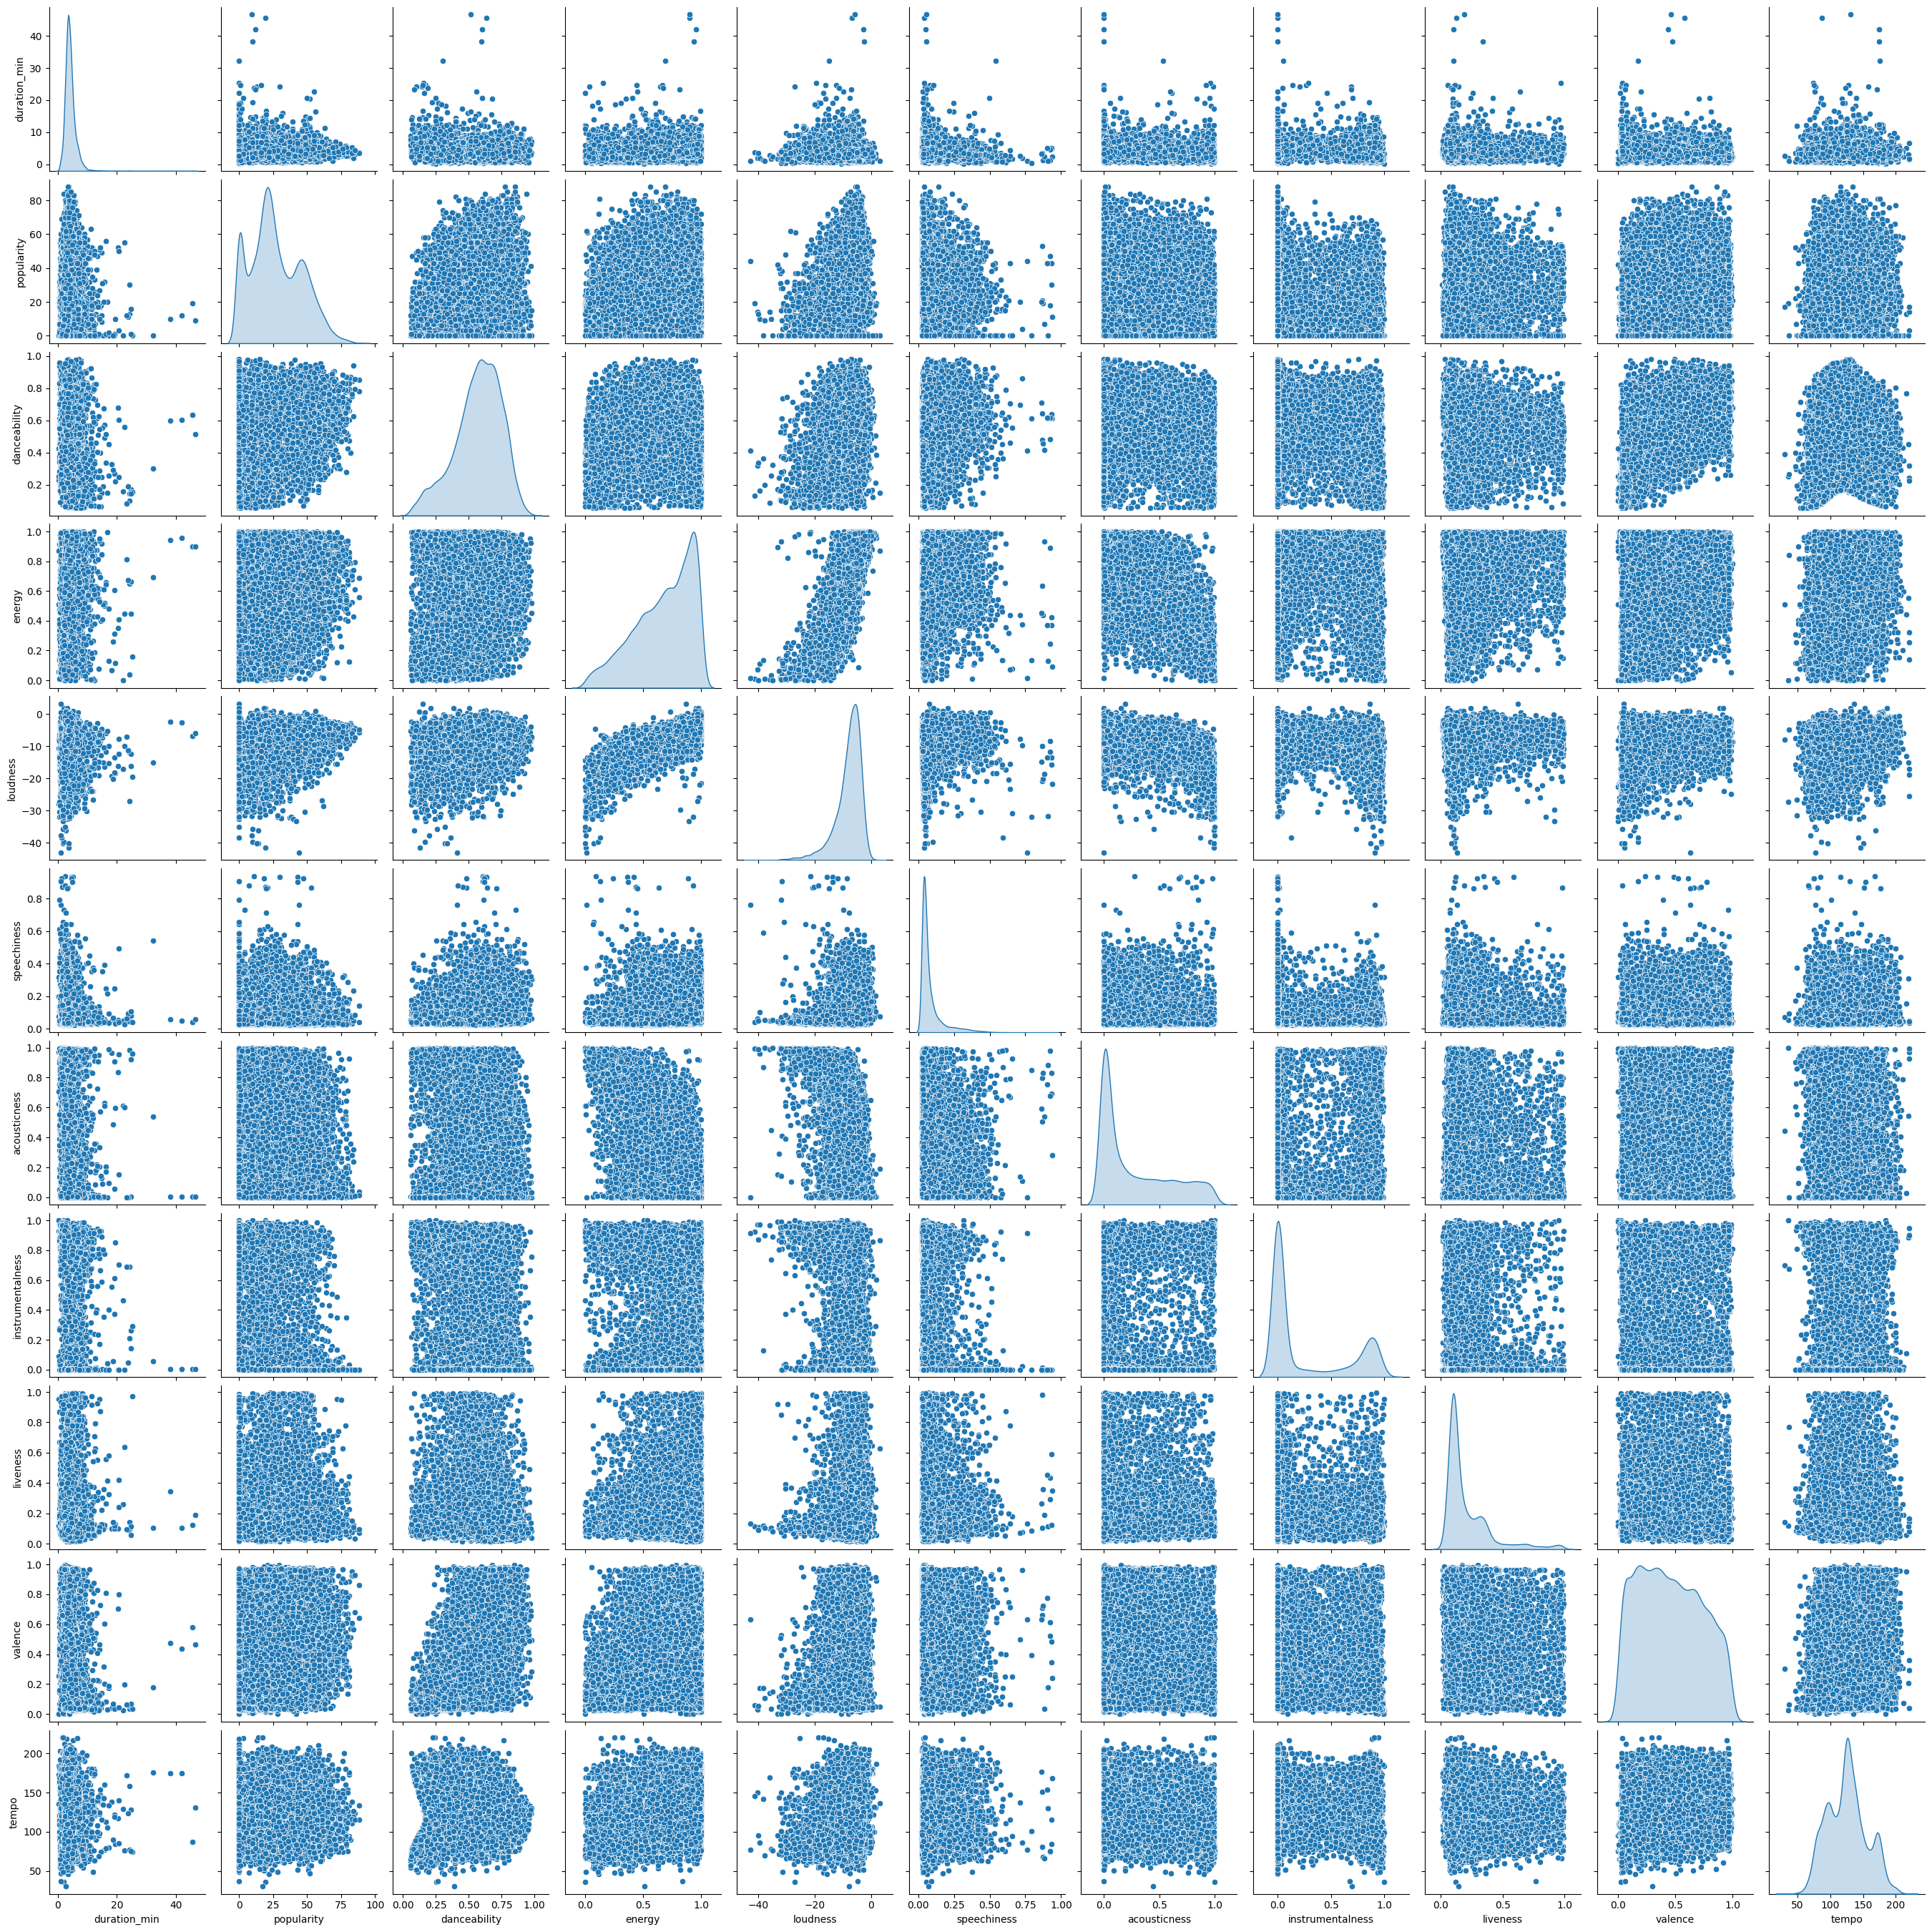

In [160]:
# let's look at distributions
sns.pairplot(dfc2,diag_kind='kde')
#kde is the distribution command for diagonal plot
plt.show()

<Axes: xlabel='key', ylabel='Count'>

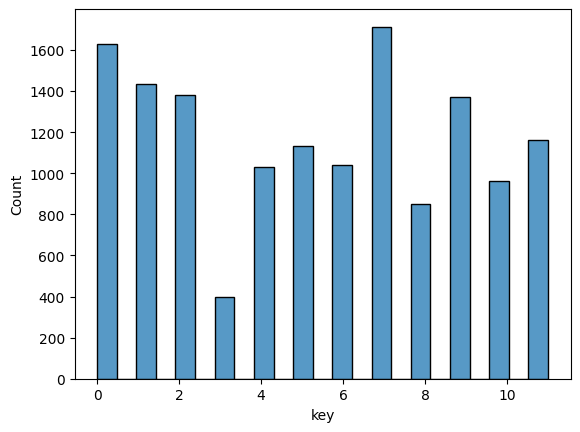

In [35]:
sns.histplot(df['key'])

Being none of them really uniform, the chosen normalization is the _z-score_ normalization. 

In [305]:
X = dfc.values
y = np.array(df['genre'])
y_mapped = pd.DataFrame(y).iloc[:,0]
#y_map = genre_map
#y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)
dfc.head()

duration_min  key  mode  speechiness  acousticness  instrumentalness  \
0      4.029333    5   1.0       0.0975      0.302000           0.53600   
1      7.400000    1   0.0       0.0805      0.283000           0.93400   
2      5.558433    2   0.0       0.0397      0.000089           0.80000   
3      4.496667    5   1.0       0.0765      0.066400           0.00127   
4      5.127517    7   1.0       0.0539      0.000576           0.09690   

     tempo  time_signature  
0  142.221             4.0  
1   75.596             4.0  
2  116.628             4.0  
3  140.880             4.0  
4  143.956             4.0

In [306]:
#performing z-score normalization
scaler = StandardScaler()
#scaler.fit(X)
scaler.fit(X2)
#X_scal = scaler.transform(X)
X_scal2 = scaler.transform(X2)

Index(['duration_min', 'popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'kmeans_labels'],
      dtype='object')


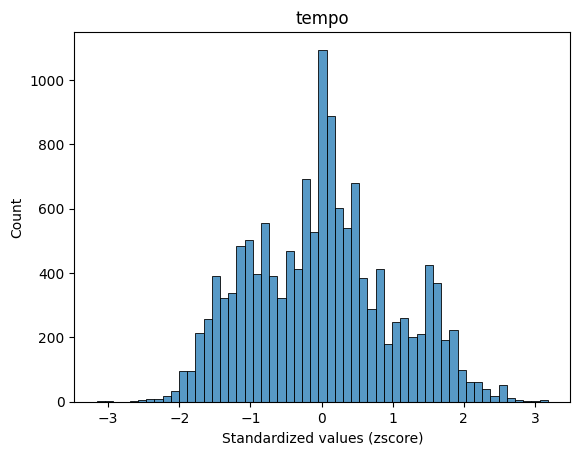

In [335]:
#just for check, plotting one of the attributes after normalization
print(dfc2.columns)
i = 10
sns.histplot(X_scal2[:,i])
plt.title(dfc2.columns[i])
plt.xlabel("Standardized values (zscore)")
plt.show()

In [321]:
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=100, random_state=94)
kmeans.fit(X_scal2)

KMeans(max_iter=100, n_clusters=7, n_init=10, random_state=94)

In [312]:
kmeans.labels_

array([3, 4, 5, ..., 2, 5, 3], dtype=int32)

### Cluster validation
Need to understand if the found cluster is valid. First step is searching for the best K, using SSE trend and searching for an elbow.  
In order to cross check, other validation measures are considered:
- Silhouette coefficient (considers both compactness and separation);
- (CVNN index (see https://www.researchgate.net/publication/233799029_Understanding_and_Enhancement_of_Internal_Clustering_Validation_Measures) that in these years seems to be valid in several situations.  
In particular CVNN is not in `sklearn`, so we will try to define it manually, see https://github.com/clslabMSU/clustGUI/blob/master/internal_validation.py)

In [279]:
#Defining the function for CVNN index
#It has to be computed for every point
def CVNN(k_neighbours):
    return

In [313]:
print('SSE', kmeans.inertia_) #kmeans.inertia_ is the SSE value
print('Silhouette', silhouette_score(X_scal2, kmeans.labels_))

SSE 86454.81250324252
Silhouette 0.15516990586590582


In [314]:
%%time
sse_list = []
#Trying different K values for K-means
for k in range(1, 200):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_scal2)
    sse_list.append(kmeans.inertia_)

CPU times: user 1h 17min 12s, sys: 9min 50s, total: 1h 27min 2s
Wall time: 24min 53s


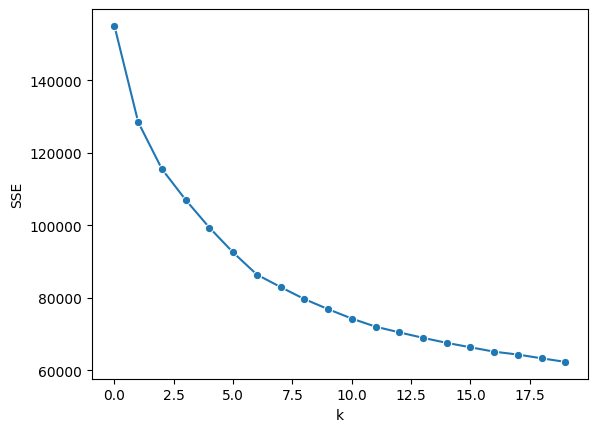

In [320]:
#Remember not to overwrite sse_list bc takes circa 12 min to recompute
sliceList = sse_list[:20]
sns.lineplot(x=range(len(sliceList)), y=sliceList, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

Maybe 200 is enough. Tonight trying with 500 but no more, I think makes no sense to cluster in 500 categories, is just for inspecting the trend. 
Inspecting 'by eye', the knee seems to be at around 10. 

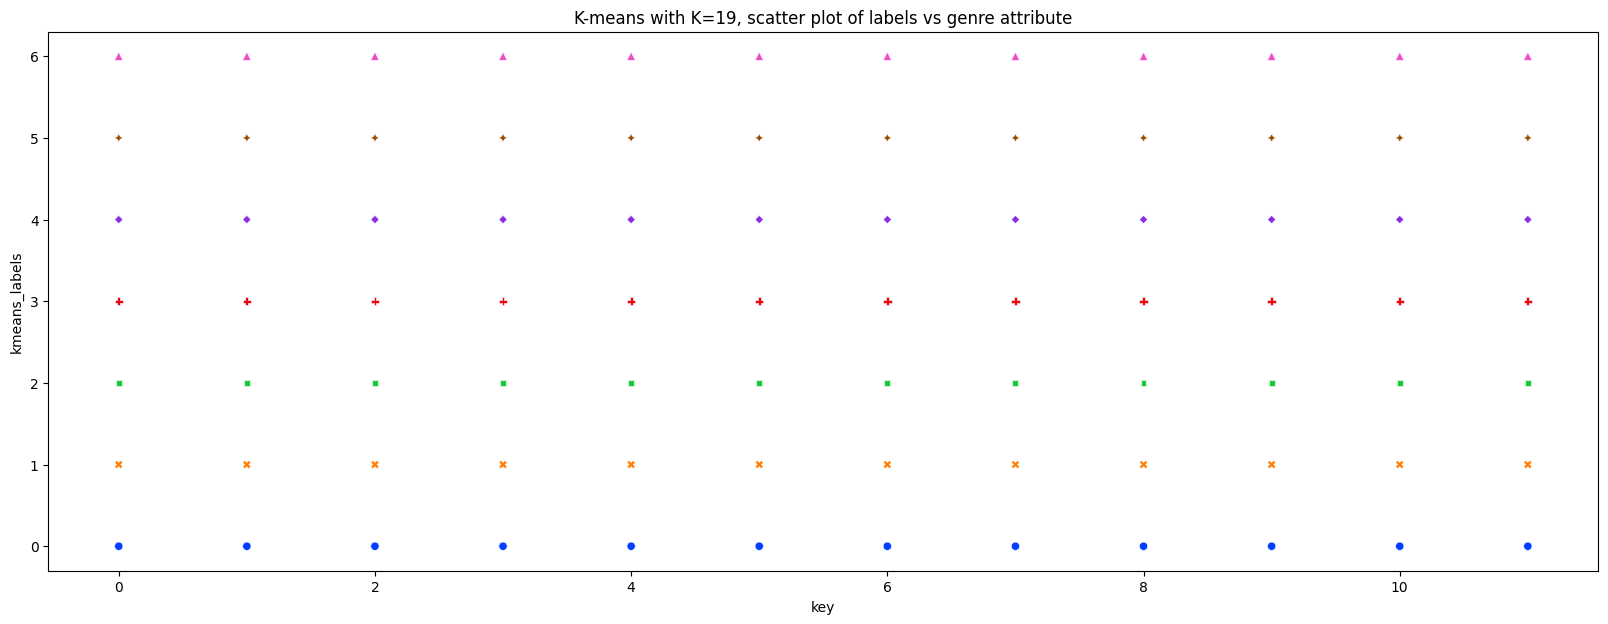

In [322]:
df['kmeans_labels'] = kmeans.labels_
plt.figure(figsize=(20,7))
plt.title('K-means with K=19, scatter plot of labels vs genre attribute')
sns.scatterplot(data=df, x="key", y="kmeans_labels", hue=kmeans.labels_, 
                style='kmeans_labels', palette="bright",legend=False)
plt.show()

This is not particularly interesting but the holes indicates that some genre does not stay in some cluster.
I was hoping in something more interesting anyway.  
This can be used for concluding that with k-means the regroup by genra is not possible. 
See correlation between `kmeans_labels` and the other attributes. 

<Axes: title={'center': 'Correlation with Spearman method - linear correlation coefficients'}>

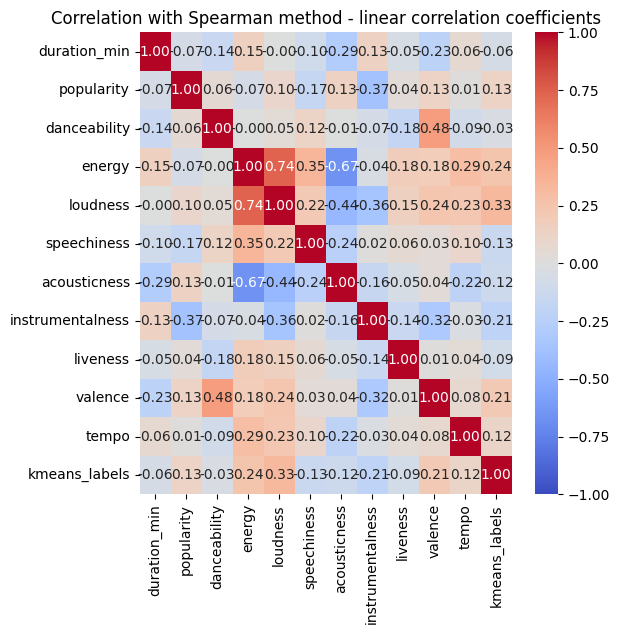

In [325]:
#Looking at correlations between attributes used for clustering and kmeans_labels.
dfc2=df[['duration_min','popularity', 'danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','kmeans_labels']]
plt.figure(figsize=(6,6))
plt.title('Correlation with Spearman method - linear correlation coefficients')
sns.heatmap(dfc2.corr(numeric_only=True, method='spearman'), cmap="coolwarm", vmin=-1,fmt='.2f', vmax=1, annot=True)

Looking at the last column, _it is possible to see the 'contribution' of every attribute to clustering lables_???

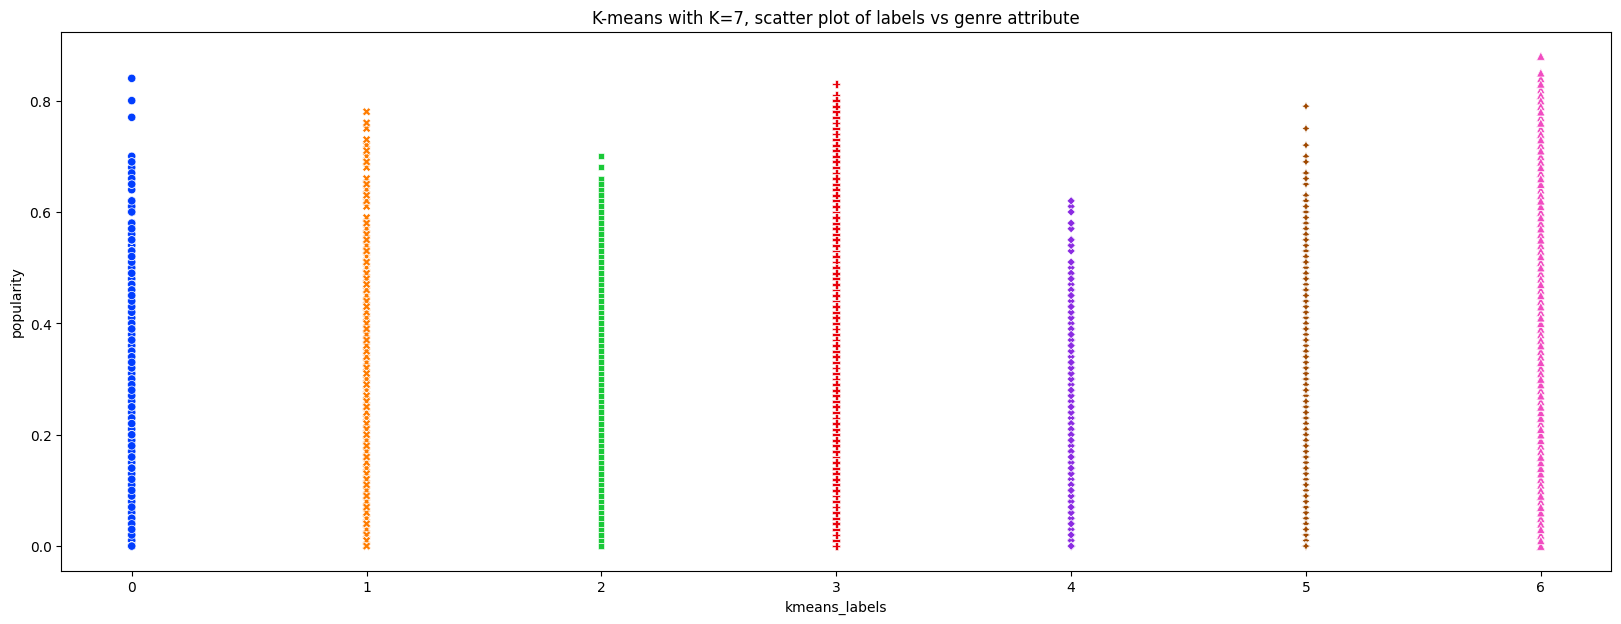

In [326]:
df['kmeans_labels'] = kmeans.labels_
plt.figure(figsize=(20,7))
plt.title('K-means with K=7, scatter plot of labels vs genre attribute')
sns.scatterplot(data=df, y="popularity", x="kmeans_labels", hue=kmeans.labels_, 
                style='kmeans_labels', palette="bright",legend=False)
plt.show()

In [286]:
sns.pairplot(dfc2,diag_kind='kde')
#kde is the distribution command for diagonal plot
plt.show()

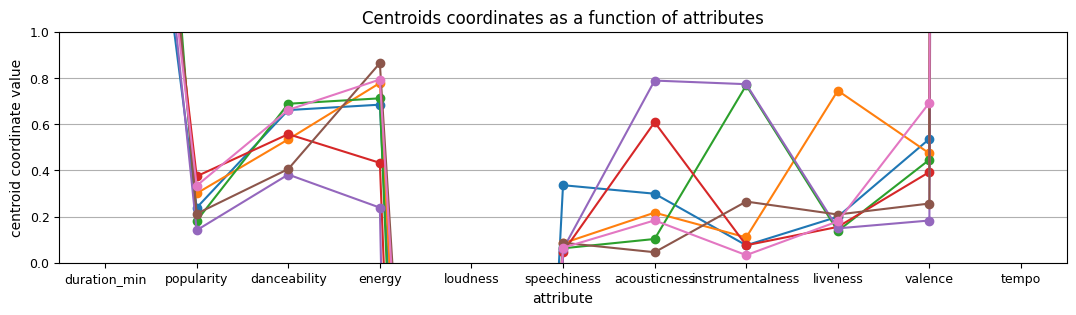

In [341]:
plt.figure(figsize=(13, 3))

#clust_name = ['A', 'B', 'C']
#being loudness and tempo not percentuals, it is needed to rescale. 

for i in range(len(centers)):
    #print(f'{i}th centroid: {centers[i]}')
    plt.plot(centers[i], marker='o')
    
plt.title('Centroids coordinates as a function of attributes')
plt.xticks(range(0,len(dfc2.columns) - 1), dfc2.columns[:-1], fontsize=9)
plt.xlabel('attribute')

plt.yticks(fontsize=9)
plt.ylabel('centroid coordinate value')
plt.ylim(0,1)


#plt.legend(fontsize=9, loc='best')
plt.grid(axis='y')

Looking at this plot, it is possible to see that the centroids are more distinct for the following attributes:
- `loudness`,
- `tempo`.
But the deal is that those are the attributes with range different from \[0,1\]. It is necessary to rescale. 
Considering only range \[0,1\]: it is possible to visualize distance in terms of percentual quantities (that are the most).  
The following attributes seems pretty useful for division:
- `acousticness`;
- `valence`.

Index(['duration_min', 'popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'kmeans_labels'],
      dtype='object')


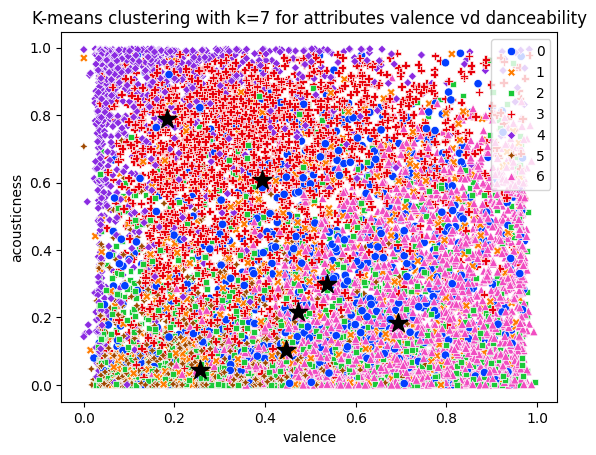

In [342]:
#Saving centroids
print(dfc2.columns)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
sns.scatterplot(data=dfc2, 
                x="valence", 
                y="acousticness", 
                hue='kmeans_labels', 
                style='kmeans_labels',
                palette="bright",
               )
plt.legend()
plt.title('K-means clustering with k=7 for attributes valence vd danceability')
plt.scatter(centers[:,9], centers[:,6], c='black', marker='*', s=200)
plt.show()

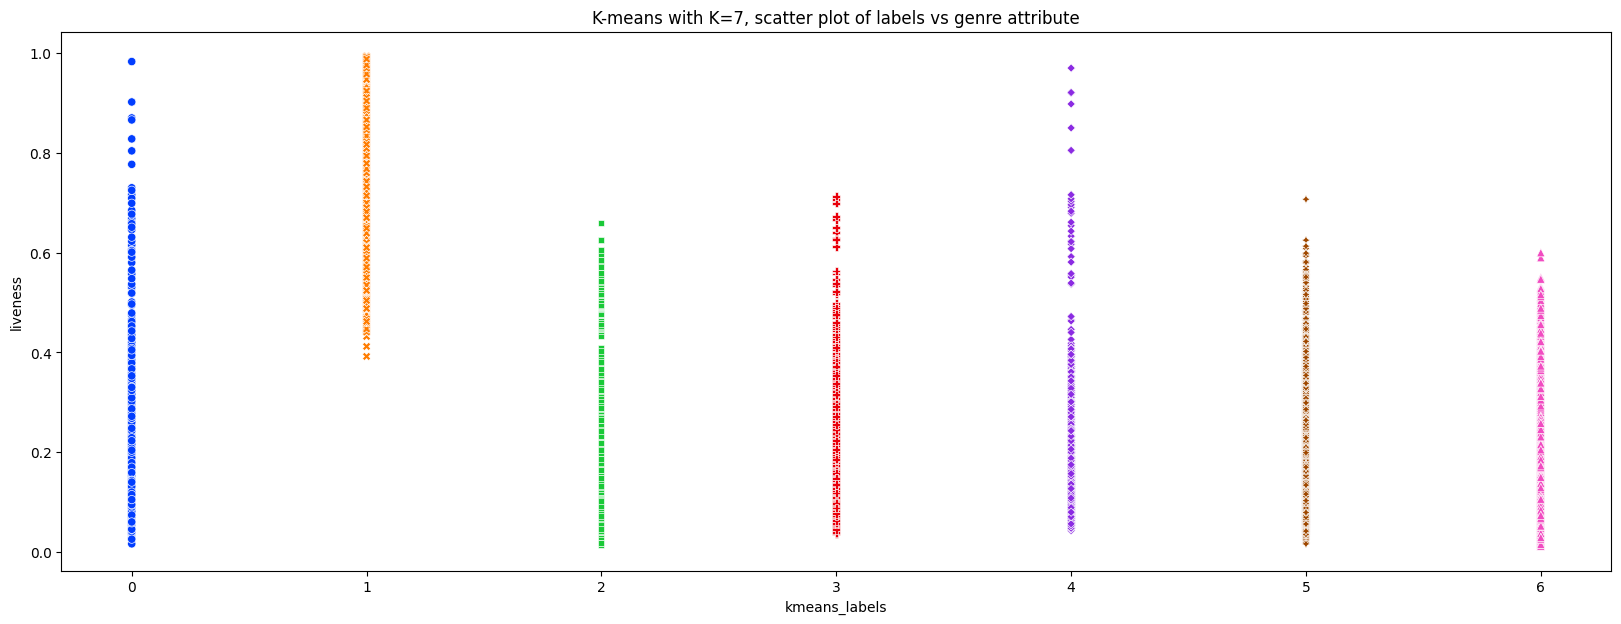

In [343]:
df['kmeans_labels'] = kmeans.labels_
plt.figure(figsize=(20,7))
plt.title('K-means with K=7, scatter plot of labels vs genre attribute')
sns.scatterplot(data=df, y="liveness", x="kmeans_labels", hue=kmeans.labels_, 
                style='kmeans_labels', palette="bright",legend=False)
plt.show()

In order to assure if the clustering makes sense, a p-test has to be done.  
It is necessary to sample random points, I'll do it picking values randomly from every distribution.

In [346]:
dfc2.columns

Index(['duration_min', 'popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'kmeans_labels'],
      dtype='object')

In [370]:
def random_sampler(n_points : int=15000) -> np.array:
    #the following function creates random samples
    points = np.array([]) #this will contain points
    tmp=np.array([]) #this will contain a single random point
    for i in range(n_points):
        y=max(df['duration_min'])*np.random.random()
        print(y)
        np.append(np.mean(df['duration_min'])*np.random.random(),tmp)
        np.append(np.random.random(1),tmp)
        np.append(np.random.random(1),tmp)
        np.append(np.random.random(1),tmp)
        np.append(np.random.random(1)*(max(df['loudness']-min(df['loudness']))+min(df['loudness'])),tmp)
        np.append(np.random.random(1),tmp)
        np.append(np.random.random(1),tmp)
        np.append(np.random.random(1),tmp)
        np.append(np.random.random(1),tmp)
        np.append(np.random.random(1),tmp)
        np.append(np.random.random(1)*max(df['tempo']),tmp)
        
        np.append(tmp,points)
        print(points)
        
    return points
            
            
        
    

In [371]:
x = random_sampler(1)
print(x)

14.15551350015659
[]
[]


### Hierarchical trial before I start crying

In [19]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [84]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=None, n_clusters=8, metric=custom_distance, linkage='complete', compute_distances=True, compute_full_tree=False)
model = model.fit(X_scal)

TypeError: custom_distance() missing 1 required positional argument: 'x2'

TypeError: dendrogram() got an unexpected keyword argument 'metric'

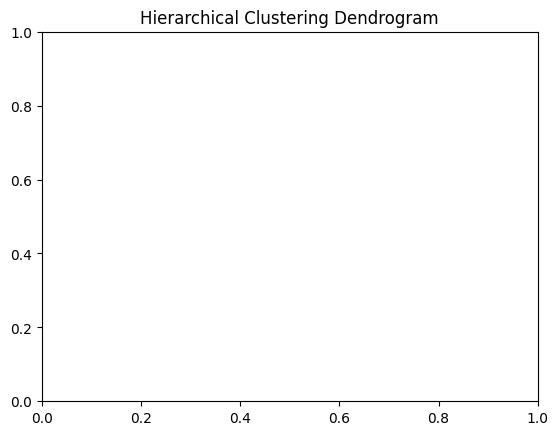

In [82]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp", above_threshold_color='r')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Cluster validity measure
As described in the following article: https://pubmed.ncbi.nlm.nih.gov/23193245/, the 'safest' internal measure is the CVNN, where the integer $k$ has to be decided (doing multiple trials).  

As external measure, the idea is to confront the cluster labels with the `genre` classification. 